## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:

In [0]:
import pandas as pd
import numpy as np
from scipy import stats

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

In [0]:
votes = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])
votes = votes.replace({'?':np.NaN, 'n':0, 'y':1})
democrat = votes[votes['party'] == 'democrat']
republican = votes[votes['party'] == 'republican']

**1. Generate and numerically represent a confidence interval**

Confidence interval = the bounds of statistical significance for the t-test

Confidence interval = sample mean +/- margin of error

Margin of error = t-statistic (threshold?) * (standard deviation / square root of n)


In [0]:
# FILL MISSING VALUES (IS THIS METHODOLOGY CORRECT?)
republican = republican.fillna(0.5)

In [0]:
mean = np.mean(republican['education'])

In [0]:
s = np.std(republican['education'], ddof=1)

In [0]:
n = len(republican['education'])

In [0]:
se = s / np.sqrt(n)

In [0]:
t = stats.t.ppf(1.95 / 2.0, n-1)

In [0]:
moe = t * se

In [11]:
print('Mean:', mean)
print('Lower Bound:', mean - moe)
print('Upper Bound:', mean + moe)

Mean: 0.8422619047619048
Lower Bound: 0.7907902004041876
Upper Bound: 0.893733609119622


In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
#  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = (np.std(data, ddof=1) / np.sqrt(n))
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  moe = stderr * t
  return (mean, mean - moe, mean + moe)

In [13]:
confidence_interval(republican['education'])

(0.8422619047619048, 0.7907902004041876, 0.893733609119622)

**2. Graphically (with a plot) represent the confidence interval**

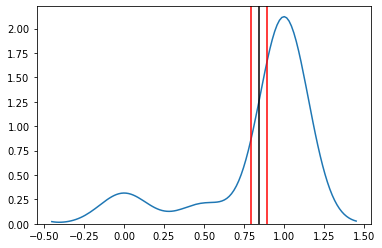

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = republican['education']

#sns.distplot(plot_data, kde=False, bins=3)
sns.kdeplot(plot_data.values, bw=0.15)
ci = confidence_interval(plot_data)
plt.axvline(x=ci[1], color='red')
plt.axvline(x=ci[2], color='red')
plt.axvline(x=ci[0], color='k');

**3. Interpret the confidence interval - what does it tell you about the data and its distribution?**

We can say with 95% confidence that the average republican vote on 'education' within the larger population would be between 0.82 and 0.92, with the mean being 0.87.

### Chi-squared tests:

**4. Take a dataset that we have used in the past in class that has *categorical* variables. Pick two of those categorical variables and run a chi-squared tests on that data**

**Chi-squared interpretation**

A test using categorical (binned) variables.

Null hypothesis = True. Meaning there is not a statistically significant difference between the observed and expected categories/variables. Observed - Expected = 0.

The test statistic is a value under the chi-squared distribution...?

In [0]:
from scipy.stats.distributions import chi2

In [0]:
# USING LOAN STATS DATA
!wget https://resources.lendingclub.com/LoanStats_2018Q4.csv.zip
!unzip LoanStats_2018Q4.csv.zip

In [0]:
df = pd.read_csv('LoanStats_2018Q4.csv', header=1, skipfooter=2, 
                 engine='python')

**- By hand using Numpy**

In [18]:
# GENERATE CROSSTAB WITH MARGINS
crosstab = pd.crosstab(df['purpose'], df['grade'], margins=True)
crosstab

grade,A,B,C,D,E,F,G,All
purpose,,,,,,,,
car,275,284,231,175,62,8,2,1037
credit_card,14177,10192,6989,2849,715,31,8,34961
debt_consolidation,18888,19907,18187,10039,3362,184,36,70603
home_improvement,2021,2046,1844,1166,402,30,3,7512
house,128,202,218,180,81,7,7,823
major_purchase,516,599,582,399,183,18,6,2303
medical,314,345,412,297,123,8,0,1499
moving,124,156,179,132,57,6,2,656
other,1173,1674,1853,1469,808,84,33,7094


In [0]:
# CALCULATE ROW/COLUMN SUMS
row_sums = crosstab.iloc[:-1,-1].values
col_sums = crosstab.iloc[-1,:-1].values
total = crosstab.iloc[-1,-1]

In [20]:
# NESTED FOR LOOP TO GET 2D LIST/ARRAY OF EXPECTED RESULTS
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)
expected.shape

(12, 7)

In [21]:
# CROSSTAB OF OBSERVED RESULTS
observed = pd.crosstab(df['purpose'], df['grade'])
observed.shape

(12, 7)

In [22]:
# NEED TO FIGURE OUT HOW TO INTERPRET THESE VALUES
chi_sq = ((observed - expected)**2 / (expected)).sum()
print('Chi-Squared:', chi_sq)

Chi-Squared: grade
A    2253.412891
B     114.473931
C     361.866114
D    1267.194171
E    1463.099858
F     296.850718
G     242.063363
dtype: float64


In [23]:
# DEGREES OF FREEDOM: # rows - 1 * # columns - 1
dof = (len(row_sums)-1) * (len(col_sums)-1)
print('Degrees of Freedom: ', dof)

Degrees of Freedom:  66


In [24]:
chi_p_value = chi2.sf(chi_sq, dof)
print('P-Value (Chi Squared):', chi_p_value)

P-Value (Chi Squared): [0.00000000e+000 2.01813181e-004 2.11877140e-042 1.23765877e-221
 3.52318113e-262 5.15503211e-031 6.32211478e-022]


**- In a single line using Scipy**

In [25]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print('Chi-Squared:', chi_squared)
print('P-value:', p_value)
print('Degrees of Freedom:', dof) 
# print('Expected:', np.array(expected))

Chi-Squared: 5998.961045955249
P-value: 0.0
Degrees of Freedom: 66


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)